# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# udacity virtual machine?
vm_ = False
if vm_:
    # select version 1 (with a single agent) of the environment
    env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
else:
    env = UnityEnvironment(file_name='data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

# Useful Functions

def act(env, actions, brain_name="ReacherBrain") -> tuple:
    """Sends actions to the environment env and observes the results.
    Returns a tuple of rewards, next_states, dones (One per agent)"""
    action_result = env.step(actions)[brain_name] # Act on the environment and observe the result
    return (action_result.rewards,
            action_result.vector_observations, # next states
            action_result.local_done) # True if the episode ended
    
def reset(env, training=True, brain_name="ReacherBrain") -> np.ndarray:
    """Resetting the unity environment"""
    return env.reset(train_mode=training)[brain_name].vector_observations

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Ready for training

In the next code cell, we shall start our preparation for training

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
# Invite our agent & import torch
from ddpg_agent import Agent
import torch

In [6]:
def train2(agent, env, num_episodes, log_freq, max_t=20000):        
    score_hist = np.zeros((num_agents, 1))
    
    # Train
    for i in range(num_episodes):
        states = reset(env)
        scores = np.zeros(num_agents)
        for j in range(max_t): # Safer than while
            # Decide
            #state = states.squeeze() # One agent only
            actions = agent.act(states)  # Choose an action based on the state
            #actions = np.expand_dims(action, 0) # One agent only
            # Act
            rewards, next_states, dones = act(env, actions)     # Send the actions to the environment
            scores += rewards                         # update the score (for each agent)
            # Learn
            agent.step(states, actions, rewards[0], next_states[0], dones[0]) # Learn step
            # Step
            states = next_states                               # roll over states to next time step
            # Exit
            if np.any(dones):                                  # exit loop if episode finished
                break       
        # Logging
        score_hist = np.concatenate((score_hist, scores[:, None]), axis=1)
        if (i % log_freq == 0) and (i > 0):
            print(f'Average score of episodes {i-log_freq+1}-{i+1}: {np.mean(score_hist.squeeze()[-log_freq:])}')
        
        if np.mean(score_hist.squeeze()[-100:]) >= 30:
            print(f'Solved in {i} steps!')
            break
            
    return score_hist.squeeze()

def train(agent, env, num_episodes, log_freq, max_t=20000):        
    score_hist = np.zeros((num_agents, 1))
    
    # Train
    for i in range(num_episodes):
        states = reset(env)
        agent.reset()
        scores = np.zeros(num_agents)
        for j in range(max_t): # Safer than while
            # Decide
            #state = states.squeeze() # One agent only
            actions = agent.act(states)  # Choose an action based on the state
            #actions = np.expand_dims(action, 0) # One agent only
            # Act
            rewards, next_states, dones = act(env, actions)     # Send the actions to the environment
            scores += rewards                         # update the score (for each agent)
            # Learn
            agent.step(states, actions, rewards[0], next_states[0], dones[0]) # Learn step
            # Step
            states = next_states                               # roll over states to next time step
            # Exit
            if np.any(dones):                                  # exit loop if episode finished
                break       
        # Logging
        score_hist = np.concatenate((score_hist, scores[:, None]), axis=1)
        if (i % log_freq == 0) and (i > 0):
            print(f'Average score of episodes {i-log_freq+1}-{i+1}: {np.mean(score_hist.squeeze()[-log_freq:])}')
        
        if np.mean(score_hist.squeeze()[-100:]) >= 30:
            print(f'Solved in {i} steps!')
            break
            
    return score_hist.squeeze()

Train Now!

In [7]:
agent = Agent(state_size, action_size, np.random.randint(1e5))
score_hist = train(agent, env, num_episodes=500, log_freq=10)

Average score of episodes 1-11: 0.39699999112635853
Average score of episodes 11-21: 0.9329999791458249
Average score of episodes 21-31: 1.3769999692216515
Average score of episodes 31-41: 2.378999946825206
Average score of episodes 41-51: 1.9829999556764961
Average score of episodes 51-61: 2.922999934665859
Average score of episodes 61-71: 3.2439999274909495
Average score of episodes 71-81: 2.9949999330565333
Average score of episodes 81-91: 3.756999916024506
Average score of episodes 91-101: 3.2439999274909495
Average score of episodes 101-111: 4.675999895483256
Average score of episodes 111-121: 5.257999882474541
Average score of episodes 121-131: 6.1989998614415525
Average score of episodes 131-141: 5.4069998791441325
Average score of episodes 141-151: 6.585999852791429
Average score of episodes 151-161: 7.516999831981957
Average score of episodes 161-171: 8.865999801829457
Average score of episodes 171-181: 6.510999854467809
Average score of episodes 181-191: 8.31899981405586
Aver

## Plot

In [8]:
from matplotlib import pyplot as plt

INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...
INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face.  Unknown file format.


In [9]:
def moving_average(signal:np.ndarray , period: int):
    buffer = [np.nan] * period
    for i in range(period,len(signal)):
        buffer.append(signal[i-period:i].mean())
    return np.array(buffer)

(0.0, 500.0)

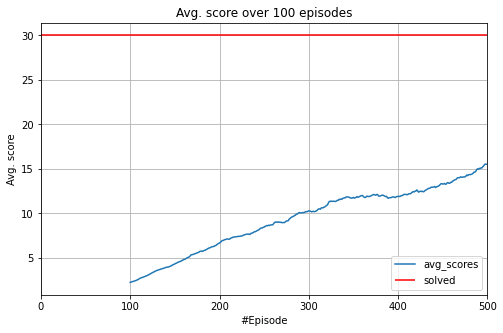

In [10]:
length = 100
avg_scores = moving_average(score_hist, length)
plt.figure(figsize=(8,5))
plt.plot(avg_scores, label='avg_scores')
plt.hlines(30, xmin=0, xmax=500, colors='r', label='solved')
plt.grid()
plt.xlabel('#Episode')
plt.ylabel('Avg. score')
plt.title(f'Avg. score over {length} episodes')
plt.legend(loc='lower right')
plt.xlim((0, 500))

## Save My Weights

In [11]:
from datetime import datetime
def save_agent(agent, avg_scores=None):
    """Saves the agent's parameters and the underlying pytorch model"""
    checkpoint = {'actor_state_dict': agent.actor_local.state_dict(),
                  'critic_state_dict': agent.critic_local.state_dict(),
                  'score_hist': score_hist}
            
    torch.save(checkpoint, 'my_weights.pth')

In [12]:
save_agent(agent, avg_scores=avg_scores)

When finished, you can close the environment.

In [13]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 